## 프로젝트 : 스티커를 붙여주자

드디어 딥러닝 모델을 이용해 우리의 스티커앱을 개선해서, 이미지 속 다수의 사람에게 스티커를 붙여줄 수 있게 되었습니다. 위 그림의 예시처럼 말이죠.

여러분들도 여러분들의 작품을 통해 이 작업을 본격적으로 수행해 봅시다. 첫번째 스텝에서 제공해 드린 프로젝트 코드를 적극 활용하셔도 좋습니다.

### 필요한 Module import 

In [10]:
import tensorflow as tf
import os
import cv2
import numpy as np

import config 
from make_prior_box import prior_box
from tf_dataloader import load_dataset, _jaccard 
from tf_build_ssd_model import SsdModel

import warnings
warnings.filterwarnings(action='ignore')


## Inference(1) NMS

### NMS 구현하기
---
Grid cell을 사용하는 Object detection의 inference 단계에서 하나의 object가 여러 개의 prior box에 걸쳐져 있을 때 가장 확률이 높은 1개의 prior box를 하나로 줄여주는 **NMS(non-max suppression)**이 필요합니다. 아래 코드를 확인해 주세요.

In [1]:
def decode_bbox_tf(pre, priors, variances=None):
    """Decode locations from predictions using prior to undo
    the encoding we did for offset regression at train time.
    Args:
        pre (tensor): location predictions for loc layers,
            Shape: [num_prior,4]
        prior (tensor): Prior boxes in center-offset form.
            Shape: [num_prior,4].
        variances: (list[float]) Variances of prior boxes
    Return:
        decoded bounding box predictions xmin, ymin, xmax, ymax
    """
    if variances is None:
        variances = [0.1, 0.2]
    centers = priors[:, :2] + pre[:, :2] * variances[0] * priors[:, 2:]
    sides = priors[:, 2:] * tf.math.exp(pre[:, 2:] * variances[1])

    return tf.concat([centers - sides / 2, centers + sides / 2], axis=1)

In [2]:
def compute_nms(boxes, scores, nms_threshold=0.5, limit=200):
    """ Perform Non Maximum Suppression algorithm
        to eliminate boxes with high overlap
    Args:
        boxes: tensor (num_boxes, 4)
               of format (xmin, ymin, xmax, ymax)
        scores: tensor (num_boxes,)
        nms_threshold: NMS threshold
        limit: maximum number of boxes to keep
    Returns:
        idx: indices of kept boxes
    """
    if boxes.shape[0] == 0:
        return tf.constant([], dtype=tf.int32)
    selected = [0]
    idx = tf.argsort(scores, direction='DESCENDING')
    idx = idx[:limit]
    boxes = tf.gather(boxes, idx)

    iou = _jaccard(boxes, boxes)

    while True:
        row = iou[selected[-1]]
        next_indices = row <= nms_threshold

        iou = tf.where(
            tf.expand_dims(tf.math.logical_not(next_indices), 0),
            tf.ones_like(iou, dtype=tf.float32),
            iou)

        if not tf.math.reduce_any(next_indices):
            break

        selected.append(tf.argsort(
            tf.dtypes.cast(next_indices, tf.int32), direction='DESCENDING')[0].numpy())

    return tf.gather(idx, selected)

In [3]:
def parse_predict(predictions, priors, cfg):
    label_classes = cfg['labels_list']

    bbox_regressions, confs = tf.split(predictions[0], [4, -1], axis=-1)
    boxes = decode_bbox_tf(bbox_regressions, priors, cfg['variances'])


    confs = tf.math.softmax(confs, axis=-1)

    out_boxes = []
    out_labels = []
    out_scores = []

    for c in range(1, len(label_classes)):
        cls_scores = confs[:, c]

        score_idx = cls_scores > cfg['score_threshold']

        cls_boxes = boxes[score_idx]
        cls_scores = cls_scores[score_idx]

        nms_idx = compute_nms(cls_boxes, cls_scores, cfg['nms_threshold'], cfg['max_number_keep'])

        cls_boxes = tf.gather(cls_boxes, nms_idx)
        cls_scores = tf.gather(cls_scores, nms_idx)

        cls_labels = [c] * cls_boxes.shape[0]

        out_boxes.append(cls_boxes)
        out_labels.extend(cls_labels)
        out_scores.append(cls_scores)

    out_boxes = tf.concat(out_boxes, axis=0)
    out_scores = tf.concat(out_scores, axis=0)

    boxes = tf.clip_by_value(out_boxes, 0.0, 1.0).numpy()
    classes = np.array(out_labels)
    scores = out_scores.numpy()

    return boxes, classes, scores

---

## Inference(2) 사진에서 얼굴 찾기

### 사진에서 여러개의 얼굴을 찾아보자.

---

이제 다 왔습니다. SSD 모델을 통해 우리는 Multi-face detection 기능을 확보했습니다.
얼마나 잘 해내는지 확인해 보도록 합시다.

In [4]:
def pad_input_image(img, max_steps):
    """pad image to suitable shape"""
    img_h, img_w, _ = img.shape

    img_pad_h = 0
    if img_h % max_steps > 0:
        img_pad_h = max_steps - img_h % max_steps

    img_pad_w = 0
    if img_w % max_steps > 0:
        img_pad_w = max_steps - img_w % max_steps

    padd_val = np.mean(img, axis=(0, 1)).astype(np.uint8)
    img = cv2.copyMakeBorder(img, 0, img_pad_h, 0, img_pad_w,
                             cv2.BORDER_CONSTANT, value=padd_val.tolist())
    pad_params = (img_h, img_w, img_pad_h, img_pad_w)

    return img, pad_params

In [5]:
def recover_pad_output(outputs, pad_params):
    """
        recover the padded output effect

    """
    img_h, img_w, img_pad_h, img_pad_w = pad_params

    recover_xy = np.reshape(outputs[0], [-1, 2, 2]) * \
                 [(img_pad_w + img_w) / img_w, (img_pad_h + img_h) / img_h]
    outputs[0] = np.reshape(recover_xy, [-1, 4])

    return outputs

In [6]:
def show_image(img, boxes, classes, scores, img_height, img_width, prior_index, class_list):
    """
    draw bboxes and labels
    out:boxes,classes,scores
    """
    # bbox

    x1, y1, x2, y2 = int(boxes[prior_index][0] * img_width), int(boxes[prior_index][1] * img_height), \
                     int(boxes[prior_index][2] * img_width), int(boxes[prior_index][3] * img_height)
    if classes[prior_index] == 1:
        color = (0, 255, 0)
    else:
        color = (0, 0, 255)
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
    # confidence

    # if scores:
    #   score = "{:.4f}".format(scores[prior_index])
    #   class_name = class_list[classes[prior_index]]

    #  cv2.putText(img, '{} {}'.format(class_name, score),
    #              (int(boxes[prior_index][0] * img_width), int(boxes[prior_index][1] * img_height) - 4),
    #              cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255))

inference와 화면출력을 위한 몇가지 기능을 추가하였습니다.

여러 사람의 얼굴이 포함된 테스트용 이미지를 골라 주세요. **`~/aiffel/face_detector/image.png`**라는 경로로 저장 후 아래 코드를 실행해 보세요.

[*] model path : /home/ssac27/aiffel/face_detector/checkpoints/weights_epoch_100.h5
[*] Predict /home/ssac27/aiffel/face_detector/image.png image.. 
[*] image.shape:(256, 384, 3)
[*] scores:[0.9973863  0.9497202  0.8504004  0.84510845]
[*] boxes:[[0.09457996 0.4289357  0.17245075 0.54027706]
 [0.49819195 0.43223998 0.5735923  0.5380017 ]
 [0.7213179  0.42415696 0.8009161  0.5373392 ]
 [0.30025882 0.43129602 0.3726101  0.53268826]]
[*] save_img_path:/home/ssac27/aiffel/face_detector/assets/out_image.png


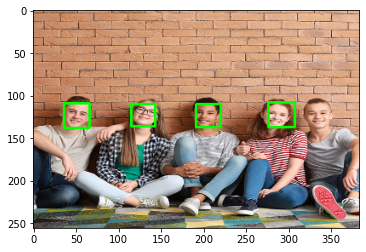

In [45]:

# hyperparameters
# args = argparse.ArgumentParser()
# args.add_argument('model_path', type=str, nargs='?', default='checkpoints/')
# args.add_argument('img_path', type=str, nargs='?', default='images/')
# args.add_argument('camera', type=str, nargs='?', default=False)

# args_config = args.parse_args()
# args_config = "images/image.png"

global model
cfg = config.cfg
min_sizes = cfg['min_sizes']
num_cell = [len(min_sizes[k]) for k in range(len(cfg['steps']))]
model_path = os.getenv('HOME')+'/aiffel/face_detector/checkpoints'
img_path = os.getenv('HOME')+'/aiffel/face_detector/image.png'
#img_path = os.getenv('HOME')+'/aiffel/face_detector/image2.jpeg'

try:
    model = SsdModel(cfg=cfg, num_cell=num_cell, training=False)

    paths = [os.path.join(model_path, path)
             for path in os.listdir(model_path)]
    latest = sorted(paths, key=os.path.getmtime)[-1]
    model.load_weights(latest)
    print(f"[*] model path : {latest}")

except AttributeError as e:
    print('Please make sure there is at least one weights at {}'.format(model_path))

if not os.path.exists(img_path):
    print(f"Cannot find image path from {img_path}")
    exit()
    
print("[*] Predict {} image.. ".format(img_path))
img_raw = cv2.imread(img_path)
img_raw = cv2.resize(img_raw, (384, 256)) #384, 256
img_height_raw, img_width_raw, _ = img_raw.shape
img = np.float32(img_raw.copy())

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# pad input image to avoid unmatched shape problem
img, pad_params = pad_input_image(img, max_steps=max(cfg['steps']))
img = img / 255.0 - 0.5

print(f"[*] image.shape:{img.shape}")

priors, _ = prior_box(cfg, image_sizes=(img.shape[0], img.shape[1]))
priors = tf.cast(priors, tf.float32)

predictions = model.predict(img[np.newaxis, ...])

boxes, classes, scores = parse_predict(predictions, priors, cfg)

print(f"[*] scores:{scores}")

# recover padding effect
boxes = recover_pad_output(boxes, pad_params)

print(f"[*] boxes:{boxes}")

# draw and save results
# save_img_path = os.path.join('assets/out_' + img_path)
save_img_path = os.getenv('HOME')+'/aiffel/face_detector/assets/out_image.png'
print(f"[*] save_img_path:{save_img_path}")

for prior_index in range(len(boxes)):
    score = "{:.4f}".format(scores[prior_index])
    class_name = cfg['labels_list']
    show_image(img_raw, boxes, classes, scores, img_height_raw, img_width_raw, prior_index, cfg['labels_list'])

cv2.imwrite(save_img_path, img_raw)
cv2.imshow('results', img_raw)
img_rgb = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

# if cv2.waitKey(0) == ord('q'):
#     exit(0)
if cv2.waitKey(100) and 0xFF == ord('q'):
    exit(0)
cv2.destroyAllWindows()